In [4]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import pandas as pd

In [5]:
hsi_path = 'train_data/1121.npz'
gt_path = 'train_gt.csv'
wavelength_path = 'wavelengths.csv'

In [6]:
gt_df = pd.read_csv(gt_path)
gt_df
wavelength_df = pd.read_csv(wavelength_path)
wavelength_df.head()

,band_no,wavelength
0,1,462.08
1,2,465.27
2,3,468.47
3,4,471.67
4,5,474.86


(116, 108)


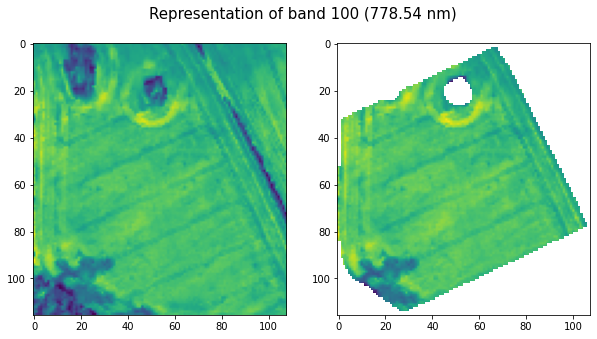

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]
with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

print(arr[band_id].data.shape)
axs[0].imshow(arr[band_id].data)
axs[1].imshow(arr[band_id])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

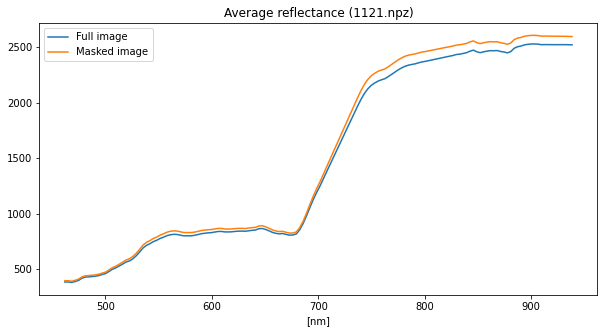

In [8]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i].data.mean() for i in range(arr.shape[0])]
masked_fft=abs(np.fft.fftshift(np.fft.fft(masked_scene_mean_spectral_reflectance)))/100
plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

In [9]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]  #len=4
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [10]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr/10000)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train = load_data("train_data")
y_train = load_gt("train_gt.csv")
#X_test = load_data("test_data")
#print(X_train)
#print(y_train)
print(f"Train data shape: {X_train.shape}")
#print(f"Test data shape: {X_test.shape}")


Train data shape: (1732, 150)


In [11]:
#Generating the baseline predictions:
#First we randomly shuffle the data:
Data=np.array(list(zip(X_train,y_train)),dtype=object)
np.random.shuffle(Data)
X_train_new=np.array([x for x in Data[:1500,0]])
y_train_new=np.array([y for y in Data[:1500,1]])
X_test_new=np.array([x for x in Data[1500:,0]])
y_test_new=np.array([y for y in Data[1500:,1]])
baseline_reg=BaselineRegressor()
# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test_new)
baselines = np.mean((y_test_new - baseline_predictions) ** 2, axis=0)
baselines

array([6.15887561e+02, 3.21840240e+03, 1.67528088e+03, 7.41945284e-02])

In [17]:
Linear_regressor=nn.Linear(150,4,bias=True)
loss=nn.MSELoss()
num_epochs=100
mini_batch_size=50
x_train_for_plots = torch.from_numpy(X_train_new.astype(np.float32))
y_train_for_plots = torch.from_numpy(y_train_new.astype(np.float32))
X_test_for_plots = torch.from_numpy(X_test_new.astype(np.float32))
y_test_for_plots = torch.from_numpy(y_test_new.astype(np.float32))
l_vec = []
l2_vec = []
dataset=TensorDataset(torch.from_numpy(X_train_new.astype(np.float32)),torch.from_numpy(y_train_new.astype(np.float32)))
for epoch in range(num_epochs):
    mini_batches=DataLoader(dataset=dataset,batch_size=mini_batch_size,shuffle=True)
    optimizer=torch.optim.SGD(params=Linear_regressor.parameters(),lr=0.1*(1.00001 - epoch/num_epochs),weight_decay=0.001)
    for mini_batch_in,mini_batch_out in mini_batches:
        outs=Linear_regressor(mini_batch_in)
        l=loss(outs,mini_batch_out)
        l.backward()
        optimizer.step()
    with torch.no_grad():
        out = Linear_regressor(x_train_for_plots)
        out2 = Linear_regressor(X_test_for_plots)
        l_vec.append(loss(out,y_train_for_plots))
        l2_vec.append(loss(out2,y_test_for_plots))
    optimizer.zero_grad()

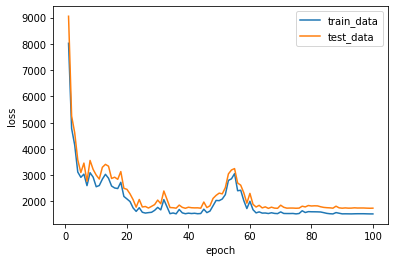

In [31]:
plt.plot(range(1,101),l_vec,label='train_data')
plt.plot(range(1,101),l2_vec,label='test_data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [32]:
#Predictions of the network:
X_test_tensor=torch.from_numpy(X_test_new.astype(np.float32))
with torch.no_grad():
    predictions_tensor=Linear_regressor(X_test_tensor)
predictions=predictions_tensor.numpy()

In [33]:
mse=np.mean((predictions-y_test_new)**2,axis=0)

scores=mse/baselines

final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 0.9840362617658599
Class K score: 0.9988136941065369
Class Mg score: 0.9758477559428554
Class pH score: 0.9853148806304799
Final score: 0.986003148111433


In [29]:
predictions

array([[ 70.69394  , 228.68604  , 166.02618  ,   6.7841372],
       [ 71.17561  , 227.04852  , 166.48524  ,   6.7946916],
       [ 71.2885   , 229.73674  , 151.93063  ,   6.7490063],
       [ 69.08032  , 225.93938  , 161.97089  ,   6.8077846],
       [ 67.82168  , 227.17923  , 161.44197  ,   6.781129 ],
       [ 69.420784 , 228.57886  , 157.03625  ,   6.758746 ],
       [ 68.81825  , 227.27039  , 160.20107  ,   6.782128 ],
       [ 70.879456 , 227.1415   , 157.48889  ,   6.803528 ],
       [ 71.54509  , 229.46292  , 151.71075  ,   6.754015 ],
       [ 71.58178  , 229.44115  , 151.89487  ,   6.755052 ],
       [ 71.03236  , 227.21767  , 166.49773  ,   6.8164287],
       [ 71.184456 , 228.65906  , 162.90771  ,   6.771412 ],
       [ 69.42381  , 226.99834  , 162.98242  ,   6.789815 ],
       [ 71.48088  , 229.59854  , 151.40149  ,   6.750585 ],
       [ 66.91637  , 227.01877  , 160.9558   ,   6.7776356],
       [ 74.925705 , 230.41168  , 146.91898  ,   6.756549 ],
       [ 73.91139  , 229

While the score appears better than the conv-net,the final predictions in the case of the conv-net scores better than the linear regressor.

(0.005302305714837452, 0.06596870173055112)

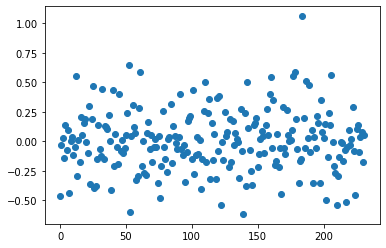

In [14]:
diff=y_test_new[:,3]-predictions[:,3]
plt.scatter(range(predictions.shape[0]),diff)
(diff.mean(),diff.var())

# Generating final predictions:

In [15]:
X_test = load_data("test_data")

In [16]:
#Predictions of the network:
X_test_fin_tensor=torch.from_numpy(X_test.astype(np.float32))
with torch.no_grad():
    predictions_tensor_fin=Linear_regressor(X_test_fin_tensor)
predictions_fin=predictions_tensor_fin.numpy()

In [17]:
submission = pd.DataFrame(data = predictions_fin, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission_linear_reg.csv", index_label="sample_index")